# Odometry Dead Reconning

### constants

In [5]:
import numpy as np

WHEEL_DIAM = 254/100    # wheel diameter (dm)
BOT_WIDTH = 393.7/100   # distance from center of left wheel to center of right (dm)
SKID_FACTOR = 1.85  # made up scalar to account for effect of skid steering effective width for rotation

WHEEL_CIRC = np.pi*WHEEL_DIAM    # wheel circumference (dm)
ENC_TICK_LEN = WHEEL_CIRC / 360  # length of one encoder tick (dm)

### load data

In [6]:
import slam.load_data as load_data
from slam.slam_utils import get_local_movement

def get_lm_from_enc(enc_path, enc_tick_len=ENC_TICK_LEN, bot_width=BOT_WIDTH, skid_factor=SKID_FACTOR):
    """ from encoder path, return vector of local pose changes """
    # Front Right, Front Left,... encoder readings, time
    FR_enc, FL_enc, RR_enc, RL_enc, enc_ts = load_data.get_encoder(enc_path)

    R_enc = (FR_enc + RR_enc) / 2  #average value of right encoders
    L_enc = (FL_enc + RL_enc) / 2  #average value of left encoders

    local_mv = get_local_movement(R_enc, L_enc,
                                  enc_tick_len = enc_tick_len, 
                                  bot_width = bot_width * skid_factor)
    return [local_mv, enc_ts]

### Get Dead Reconning Estimate

In [7]:
from slam.slam_map import Bot
import slam.MapUtilsCython.MapUtils_fclad as mu
import slam.MapUtilsCython.update_ogm as og
from slam.slam_utils import get_occupied_coords

def dead_rec(local_mv, lidar):
    ogm = np.zeros((800,800))  # occupancy grid map
    bot = Bot(pose=[400,400,0]) # start bot in middle of map

    i = 0
    j = 0
    while ( (i < len(local_mv)) and (j < len(lidar)) ):  # loop through movement and lidar in time-sequential order
        if (enc_ts[i] < lidar[j]['t']):
            bot.move(local_mv[i])
            i += 1
        else:
            occ_coords = get_occupied_coords(np.array([bot.pose]),lidar[j]).astype(np.int16)[0]
            empty_coords = mu.getMapCellsFromRay_fclad(bot.pose[0], bot.pose[1],
                                                    occ_coords[:,0], occ_coords[:,1],
                                                    np.max(ogm.shape)).astype(np.int16, copy=True).T
            for c in occ_coords:
                ogm[c[0], c[1]] += 0.1
            for c in empty_coords:
                ogm[c[0], c[1]] -= 0.01
            j += 1
    while (i < len(local_mv)):  # loop through any remaining movement
        bot.move(local_mv[i])
        i += 1
    while (j < len(lidar)):  # loop through any remaining lidar
        for c in occ_coords:
            ogm[c[0], c[1]] += 0.1
        for c in empty_coords:
            ogm[c[0], c[1]] -= 0.01
        j += 1
    return [ogm, np.asarray(bot.trajectory)]

### 20

In [8]:
enc_path = '../data/Encoders20'
lidar_path = '../data/Hokuyo20'

local_mv20, enc_ts = get_lm_from_enc(enc_path)
lidar20 = load_data.get_lidar(lidar_path)

ogm20, traj20 = dead_rec(local_mv20, lidar20)

In [19]:
local_mv20_fubar, enc_ts = get_lm_from_enc(enc_path, skid_factor=1.5)

ogm20_fubar, traj20_fubar = dead_rec(local_mv20_fubar, lidar20)

### 21

In [10]:
enc_path = '../data/Encoders21'
lidar_path = '../data/Hokuyo21'

local_mv21, enc_ts = get_lm_from_enc(enc_path)
lidar21 = load_data.get_lidar(lidar_path)

ogm21, traj21 = dead_rec(local_mv21, lidar21)

### 23

In [11]:
enc_path = '../data/Encoders23'
lidar_path = '../data/Hokuyo23'

local_mv23, enc_ts = get_lm_from_enc(enc_path)
lidar23 = load_data.get_lidar(lidar_path)

ogm23, traj23 = dead_rec(local_mv23, lidar23)

### 22

In [12]:
enc_path = '../test/Encoders22'
lidar_path = '../test/Hokuyo22'

local_mv22, enc_ts = get_lm_from_enc(enc_path)
lidar22 = load_data.get_lidar(lidar_path)

ogm22, traj22 = dead_rec(local_mv22, lidar22)

### 24

In [13]:
enc_path = '../test/Encoders24'
lidar_path = '../test/Hokuyo24'

local_mv24, enc_ts = get_lm_from_enc(enc_path)
lidar24 = load_data.get_lidar(lidar_path)

ogm24, traj24 = dead_rec(local_mv24, lidar24)

In [14]:
traj21 = np.asarray(traj21)

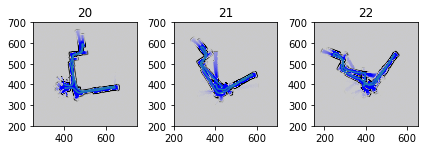

In [15]:
import matplotlib.pyplot as plt
from slam.slam_utils import slam_cmap

plt.subplot(1,3,1)
plt.imshow(ogm20.T, origin='lower', cmap=slam_cmap, vmin=-30, vmax=30)
plt.plot(traj20[:,0], traj20[:,1])
plt.axis([250,750,200,700])
plt.title('20')

plt.subplot(1,3,2)
plt.imshow(ogm21.T, origin='lower', cmap=slam_cmap, vmin=-30, vmax=30)
plt.plot(traj21[:,0], traj21[:,1])
plt.axis([200,700,200,700])
plt.title('21')

plt.subplot(1,3,3)
plt.imshow(ogm22.T, origin='lower', cmap=slam_cmap, vmin=-30, vmax=30)
plt.plot(traj22[:,0], traj22[:,1])
plt.axis([150,650,200,700])
plt.title('22')

plt.tight_layout()

Text(0.5, 1.0, 'Incorrect Width')

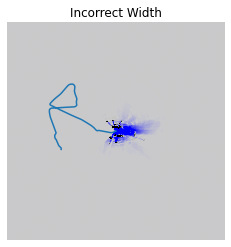

In [23]:
plt.imshow(ogm20_fubar.T, origin='lower', cmap=slam_cmap, vmin=-30, vmax=30)
plt.plot(traj20_fubar[:,0], traj20_fubar[:,1])
plt.axis('off')
plt.title('Incorrect Width')

Text(0.5, 1.0, '24')

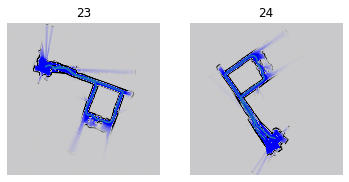

In [16]:
plt.subplot(1,2,1)
plt.imshow(ogm23.T, origin='lower', cmap=slam_cmap, vmin=-30, vmax=30)
plt.plot(traj23[:,0], traj23[:,1])
plt.axis([250,750,50,550])
plt.axis('off')
plt.title('23')

plt.subplot(1,2,2)
plt.imshow(ogm24.T, origin='lower', cmap=slam_cmap, vmin=-30, vmax=30)
plt.plot(traj24[:,0], traj24[:,1])
plt.axis([120,620,280,780])
plt.axis('off')
plt.title('24')

In [25]:
import pickle as pk

pk.dump(ogm20,open('./pickles/ogm20.pickle','wb'))
pk.dump(ogm20_fubar,open('./pickles/ogm20_fubar.pickle','wb'))
pk.dump(traj20_fubar,open('./pickles/traj20_fubar.pickle','wb'))
pk.dump(ogm21,open('./pickles/ogm21.pickle','wb'))
pk.dump(ogm22,open('./pickles/ogm22.pickle','wb'))
pk.dump(ogm23,open('./pickles/ogm23.pickle','wb'))
pk.dump(ogm24,open('./pickles/ogm24.pickle','wb'))